
Hydropower System Performance and Financial Analysis Script
============================================================

This script performs a comprehensive analysis of a hydropower system, calculating
its technical and financial metrics over a project's lifetime. The script handles
data preprocessing, turbine efficiency modeling, renewable energy estimation, and
cost-benefit analysis, presenting results through plots and outputs.

Key Features:
-------------
1. Load and preprocess historical flow data.
2. Calculate flow-duration and power-duration curves.
3. Model turbine efficiency and plant performance.
4. Estimate renewable energy available and firm power.
5. Perform financial analysis, including cash flow, NPV, IRR, and payback period.

Inputs:
-------
1. Historical flow data in an Excel file with columns:
   - "Date": Timestamps of flow readings.
   - "Flow (m³/s)": Recorded flow rates.
2. Plant and turbine parameters (e.g., gross head, design flow).
3. Financial parameters (e.g., inflation rate, discount rate).

Outputs:
--------
1. Efficiency, flow, and power data tables.
2. Power-duration and cash-flow plots.
3. Key metrics: NPV, IRR, payback period, and firm power energy.


In [32]:
# pip install numpy_financial

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy_financial as npf


SECTION 1: Load and Preprocess Flow Data
=============================================================


In [34]:
#  pip uninstall openpyxl

In [35]:
# pip install openpyxl

In [36]:
pip install --upgrade openpyxl

Note: you may need to restart the kernel to use updated packages.


In [37]:
import numpy as np
import pandas as pd

# Set the parameters for artificial flow data
days_in_year = 365  # Number of days in a year
min_flow = 1  # Minimum flow value
max_flow = 10  # Maximum flow value

# Generate random flow data using a non-uniform distribution (normal distribution, clipped to the range)
mean_flow = (min_flow + max_flow) / 9  # Mean flow value
std_dev = (max_flow - min_flow) / 10  # Standard deviation (to keep most values within range)

# Generate random data and clip it to the desired range
flow_data = np.random.normal(mean_flow, std_dev, days_in_year)
flow_data = np.clip(flow_data, min_flow, max_flow)


# Create a DataFrame with the generated data
dates = pd.date_range(start="2024-01-01", periods=days_in_year, freq="D")
Input_flow_data = pd.DataFrame({
    "Date": dates,
    "Flow (m³/s)": flow_data
})

    
# Rename columns for consistency
Input_flow_data.columns = ["Date", "Flow (m³/s)"]
Input_flow_data["Date"] = pd.to_datetime(Input_flow_data["Date"])
Input_flow_data["Flow (m³/s)"] = pd.to_numeric(Input_flow_data["Flow (m³/s)"], errors="coerce")
Input_flow_data = Input_flow_data.dropna(subset=["Flow (m³/s)"])

# Filter and sort flow data
flow_raw = Input_flow_data["Flow (m³/s)"].values
non_zero_flow = flow_raw[flow_raw > 0]
sorted_flow = np.sort(non_zero_flow)[::-1]

# Calculate exceedance percentages and flow rates
percentiles = np.arange(0, 105, 5)
len_sorted_flow = len(sorted_flow)
index = (percentiles / 100.0) * (len_sorted_flow - 1)
rate_flow = np.interp(index, np.arange(len_sorted_flow), sorted_flow)

In [38]:
pip show openpyxl


Name: openpyxl
Version: 3.1.5
Summary: A Python library to read/write Excel 2010 xlsx/xlsm files
Home-page: https://openpyxl.readthedocs.io
Author: See AUTHORS
Author-email: charlie.clark@clark-consulting.eu
License: MIT
Location: c:\users\kumab\anaconda3\lib\site-packages
Requires: et-xmlfile
Required-by: 
Note: you may need to restart the kernel to use updated packages.


Section 2: Define Plant and Financial Parameters
=============================================================


In [39]:
# Define physical parameters
Q_des = 1  # Design flow rate for a single turbine (m^3/s)
j = 2  # Number of jets
num_turbines = 2  # Total number of turbines
# Efficiency adjustment percentage (input parameter)
efficiency_adjustment = 3.0  # Enter value between -5% and 5%
rho = 1000  # Density of water (kg/m^3)
g = 9.81  # Gravitational acceleration (m/s^2)
l_t = 0.02  # Transformer loss
l_para = 0.01  # Parasitic losses
e_g = 0.97  # Generator efficiency
l_hydr_max = 0.03  # Max hydraulic loss
h_tail_max = 3  # Max tailwater effect (m)
Q_max = np.max(flow_raw)
l_dt = 0.02  # downtime loss (upto 5%)


In [40]:
# Define financial parameters
Inflation_rate=10/100 #12%
discount_rate=10/100 #12%
Project_life_time=30 #years
Debt_to_equity_ratio=66/100 #66%
Interest_rate_on_debt=8/100 #8%
Loan_term=15 #15years
project_lifetime = 30  # years
revenue_per_kwh = 0.1500  # $/kWh
base_om_cost = 931813  # Base O&M cost ($)
total_capital_cost = 25927641  # Initial equity investment ($)
residual_value_base = 30803782  # Residual value of the project ($), to be added at year 30
turbine_upgrade_cost_nominal=150000



Section 3: Define Functions for energy modeling
=============================================================


In [41]:
def rotational_speed(h, Q_d, j):
    return 31 * (h * Q_d / j) ** 0.5

def runner_diameter(h, rpm, j):
    return (49.4 * h**0.5 * j**0.02) / rpm

def turbine_peak_efficiency(d):
    return 0.864 * d**0.04

def peak_efficiency_flow(Q_d, j):
    return (0.662 + 0.001 * j) * Q_d

def efficiency_at_flow(Q, Q_p, e_p, j):
    if np.isscalar(Q):
        return 0 if Q <= 0 else e_p * (1 - ((1.31 + 0.025 * j) * abs((Q_p - Q) / Q_p) ** (5.6 + 0.4 * j)))
    else:
        Q = np.array(Q)
        efficiency = np.where(
            Q <= 0,
            0,
            e_p * (1 - ((1.31 + 0.025 * j) * abs((Q_p - Q) / Q_p) ** (5.6 + 0.4 * j)))
        )
        return efficiency
    
def hydraulic_loss(Q, Q_des):
    return gross_head * l_hydr_max * (Q**2 / Q_des**2)

def tailwater_effect(Q, Q_des, Q_max):
    if np.isscalar(Q):  # Handle single scalar values
        if Q > Q_des:
            return h_tail_max * ((Q - Q_des) ** 2 / (Q_max - Q_des) ** 2)
        return 0
    else:  # Handle arrays element-wise
        return np.where(
            Q > Q_des,
            h_tail_max * ((Q - Q_des) ** 2 / (Q_max - Q_des) ** 2), 0)

def extract_efficiency_at_flow(Q_des, efficiency_data):
  
    row = efficiency_data[efficiency_data['Flow Rate (m³/s)'] == Q_des]
    if not row.empty:
        # Extract the adjusted efficiency value and convert to decimal
        return row['Adjusted Efficiency (%)'].values[0] / 100
    else:
        return None  # Handle missing data gracefully


def plant_capacity(Q_des):
    h_hydr_des = 0.03
    h_tail_des = 0.1
    e_t_des = extract_efficiency_at_flow(Q_des, efficiency_data)
    # e_t = 0.894

    H_net = gross_head - hydraulic_losses - h_tail_des
    return rho * g * Q_des * gross_head * e_t_des * e_g * (1 - l_t) * (1 - l_para)*(1-h_hydr_des)

def power_output(Q):
    # Ensure Q is limited to Q_des if Q > Q_des
    
  
    # Calculate tailwater effect
    h_tail = tailwater_effect(Q, Q_des, Q_max)
    
    Q = np.minimum(Q, Q_des)  # Sets Q = Q_des if Q > Q_des, otherwise Q remains the same
    
    # Calculate hydraulic losses
    h_hydr = hydraulic_loss(Q, Q_des)
    
       
    # Calculate net head
    H_net = gross_head - h_hydr - h_tail

    # Calculate turbine efficiency
    e_t = efficiency_at_flow(Q, Q_p, e_p, j)  # Efficiency for the (possibly adjusted) flow
    
    # Return power output
    return rho * g * Q * H_net * e_t * e_g * (1 - l_t) * (1 - l_para)

# Renewable energy calculation
def renewable_energy_available(power_output, percentiles, l_dt=0):
 
    # Ensure power_output and percentiles are NumPy arrays
    power_output = np.array(power_output)
    percentiles = np.array(percentiles)
    
    # Convert power_output to kW if not already
    power_output_kW = power_output   # Convert MW to kW if necessary (adjust if already in kW)
    
    # Annual hours represented by each 5% increment
    hours_per_percent = 0.05 * 8760  # 5% of annual hours (8760 hours)
    
    # Initialize energy available
    energy_available = 0.0
    
    # Loop through each interval of the power curve (trapezoidal rule)
    for k in range(1, len(power_output_kW)):
        # Average power output over the interval
        avg_power = (power_output_kW[k] + power_output_kW[k - 1]) / 2
        
        # Add the contribution of this interval
        energy_available += avg_power * hours_per_percent
    
    # Adjust for downtime losses
    energy_available *= (1 - l_dt)  # Apply downtime factor
    
    return energy_available, avg_power # Energy available in kWh/year


def calculate_firm_power_energy_with_details(firm_power_curve, percentiles):
  
    # Split the Firm Power Curve into two segments
    higher_exceedance_power = firm_power_curve[18:]  # High exceedance probabilities
    lower_exceedance_power = firm_power_curve[:19]  # Low exceedance probabilities (constant section)
    
    # Constants
    time_factor = 0.98  # 5% of annual hours with 2% downtime

    # Energy and details for higher exceedance probabilities (trapezoidal rule)
    energy_higher_exceedance = 0.0
    contributing_power_higher = []  # Store trapezoidal power values
    for k in range(1, len(higher_exceedance_power)):
        # Trapezoidal area for each interval
        trapezoid_area = (higher_exceedance_power[k] + higher_exceedance_power[k - 1]) / 2
        contributing_power_higher.append((higher_exceedance_power[k], higher_exceedance_power[k - 1]))
        energy_higher_exceedance += trapezoid_area * time_factor

    # Energy and details for lower exceedance probabilities (constant power value)
    energy_lower_exceedance = 0.0
    contributing_power_lower = []  # Store constant power values
    for _ in range(1, len(lower_exceedance_power)):
        contributing_power_lower.append(firm_power_curve[18])  # Constant firm power value
        energy_lower_exceedance += firm_power_curve[18] * time_factor

    # Total energy under the Firm Power Curve
    firm_power_energy = energy_higher_exceedance + energy_lower_exceedance
    
    return firm_power_energy, contributing_power_higher, contributing_power_lower


Section 4: main energy modeling calculations
=============================================================


In [42]:

gross_head=300
hydraulic_losses = 0.03 * gross_head  # 3% of gross head
rated_head = gross_head - hydraulic_losses  # Rated head (effective head)
rpm = rotational_speed(rated_head, Q_des, j)
d = runner_diameter(rated_head, rpm, j)
e_p = turbine_peak_efficiency(d)
Q_p = peak_efficiency_flow(Q_des, j)

# Generate flow data for plotting: 0% to 100% of total plant design flow at 5% intervals
total_Q_des = num_turbines * Q_des  # Total plant design flow
flow_percentages = np.arange(0, 101, 5)
flows = [total_Q_des * (i / 100) for i in flow_percentages]  # Flow rates as percentages of total Q_des

# Calculate turbine efficiencies for each flow rate
combined_efficiencies = []
turbine_count = []  # Track the number of turbines in use

for Q in flows:
    # Determine the number of turbines in use
    active_turbines = max(1, min(num_turbines, int(np.ceil(Q / Q_des))))  # Ensure at least 1 turbine is active
    turbine_count.append(active_turbines)
    
    # Split flow among active turbines
    flow_per_turbine = Q / active_turbines if active_turbines > 0 else 0  # Avoid division by zero
    
    # Calculate efficiency for each active turbine
    individual_efficiencies = []
    for _ in range(active_turbines):
        individual_efficiencies.append(efficiency_at_flow(flow_per_turbine, Q_p, e_p, j))
    
    # Combined efficiency (weighted average of individual turbine efficiencies)
    combined_efficiency = sum(individual_efficiencies) / active_turbines if active_turbines > 0 else 0
    combined_efficiencies.append(combined_efficiency)

# Apply efficiency adjustment
adjustment_factor = (efficiency_adjustment / 100)
adjusted_efficiencies = [eff + adjustment_factor for eff in combined_efficiencies]

# Create a DataFrame to store results
efficiency_data = pd.DataFrame({
    'Flow Rate (%)': flow_percentages,
    'Flow Rate (m³/s)': flows,
    'Number of Turbines': turbine_count,
    'Original Efficiency (%)': [eff * 100 for eff in combined_efficiencies],
    'Adjusted Efficiency (%)': [eff * 100 for eff in adjusted_efficiencies]
})


e_t_des = extract_efficiency_at_flow(Q_des, efficiency_data)
P_des=plant_capacity(Q_des)/10**6
Power_output= power_output(rate_flow)/10**6
renewable_energy = renewable_energy_available(Power_output, percentiles, l_dt=l_dt)
Firm_power_curve = Power_output  # Full power duration curve (Firm Power values)
firm_energy, contributing_higher, contributing_lower = calculate_firm_power_energy_with_details(Firm_power_curve, percentiles)
energy_production_mwh =  renewable_energy[0]# MWh/year

# # NPV and IRR
print(f"Total energy under the Firm Power Curve: {firm_energy:.2f} x timefactor MWh:where  𝑡𝑖𝑚𝑒𝑓𝑎𝑐𝑡𝑜𝑟  is defined as follows: for the annual firm energy delivered  𝑡𝑖𝑚𝑒𝑓𝑎𝑐𝑡𝑜𝑟=0.05∗86700ℎ , while for the daily firm energy delivered  𝑡𝑖𝑚𝑒𝑓𝑎𝑐𝑡𝑜𝑟=0.05∗24ℎ ")
print(f"Annual available energy: {energy_production_mwh:.2f} MWh")
print(f"Plant capacity: {P_des:.2f} MW")
print(f"gross head: {gross_head:.2f} MW")



Total energy under the Firm Power Curve: 46.21 x timefactor MWh:where  𝑡𝑖𝑚𝑒𝑓𝑎𝑐𝑡𝑜𝑟  is defined as follows: for the annual firm energy delivered  𝑡𝑖𝑚𝑒𝑓𝑎𝑐𝑡𝑜𝑟=0.05∗86700ℎ , while for the daily firm energy delivered  𝑡𝑖𝑚𝑒𝑓𝑎𝑐𝑡𝑜𝑟=0.05∗24ℎ 
Annual available energy: 20223.80 MWh
Plant capacity: 2.44 MW
gross head: 300.00 MW


 Section 5: Functions for financial analysis
=============================================================


In [43]:
def calculate_om_cost(base_cost, inflation_rate, year):
    return base_cost * ((1 + inflation_rate) ** (year - 1))

def calculate_periodic_cost(base_turbine_cost, inflation_rate, year):
    return base_turbine_cost * ((1 + inflation_rate) ** (year - 1))

# Function to calculate inflation-adjusted residual value at the end of project life
def calculate_residual_value(base_value, inflation_rate, project_lifetime):
    return base_value * ((1 + inflation_rate) ** project_lifetime)

# Function to calculate annual revenue
def calculate_revenue(energy_production_mwh, revenue_per_kwh):
    return energy_production_mwh * revenue_per_kwh * 1000  # Convert MWh to kWh

# Calculate annual debt payment (using loan amortization formula)
def calculate_annual_debt_payment(principal, interest_rate, loan_term):
    r = interest_rate  # Interest rate
    n = loan_term  # Loan term in years
    return principal * (r * (1 + r) ** n) / ((1 + r) ** n - 1)

def calculate_payback_period(initial_investment, cash_flows):
    cumulative_cash_flow = 0  # Start with the initial investment
    for year, cash_flow in enumerate(cash_flows, start=1):
        cumulative_cash_flow += cash_flow
        if cumulative_cash_flow >= 0:
            # Interpolate fractional year
            fractional_year = (cumulative_cash_flow - cash_flow) / cash_flow
            return year - fractional_year
    return None  # If never paid back
def year_to_positive_cash_flow(initial_investment, cash_flows):
    cumulative_cash_flow = 0  # Start with the initial investment
    for year, cash_flow in enumerate(cash_flows, start=0):
        cumulative_cash_flow += cash_flow
        if cumulative_cash_flow >= 0:
            return year, cumulative_cash_flow  # Return the first year when cumulative cash flow is positive
    return None  # If cash flow never becomes positive


 Section 6: main financial analysis calculations
=============================================================


In [44]:
debt_amount = total_capital_cost * Debt_to_equity_ratio
equity_amount = total_capital_cost - debt_amount
initial_investment = -equity_amount
annual_debt_payment = calculate_annual_debt_payment(debt_amount, Interest_rate_on_debt, Loan_term)





# Initialize lists to store cash flow and cumulative cash flow
cash_flows = []




# Calculate cash flows for each year
# Loop through project years
for year in range(1, Project_life_time + 2):
    annual_revenue = calculate_revenue(energy_production_mwh, revenue_per_kwh)
    om_cost = calculate_om_cost(base_om_cost, Inflation_rate, year)
    turbine_cost_ir = calculate_periodic_cost(turbine_upgrade_cost_nominal, Inflation_rate, year)
    
    # Debt payment (only for the loan term)
    debt_payment = annual_debt_payment if year <= Loan_term +1 else 0

    # Calculate cash flow
    cash_flow = annual_revenue - om_cost - debt_payment

    # Add residual value in the last year
    if year == Project_life_time + 1:
        residual_value = calculate_residual_value(residual_value_base, Inflation_rate, Project_life_time)
        cash_flow += residual_value

    # Subtract turbine upgrade cost every 10 years
    if year % 10 == 1:
        cash_flow -= turbine_cost_ir

    # Update cumulative cash flow
    cash_flows.append(cash_flow)
cash_flows[0] = initial_investment




# NPV and IRR
npv = sum(cf / (1 + discount_rate) ** year for year, cf in enumerate(cash_flows, start=0))
irr = npf.irr(cash_flows)

# # NPV and IRR
print(f"Net Present Value (NPV): ${npv:,.2f}")
print(f"Internal Rate of Return (IRR): {irr:.2%}")


Net Present Value (NPV): $6,975,011.46
Internal Rate of Return (IRR): 11.48%


Plots
======

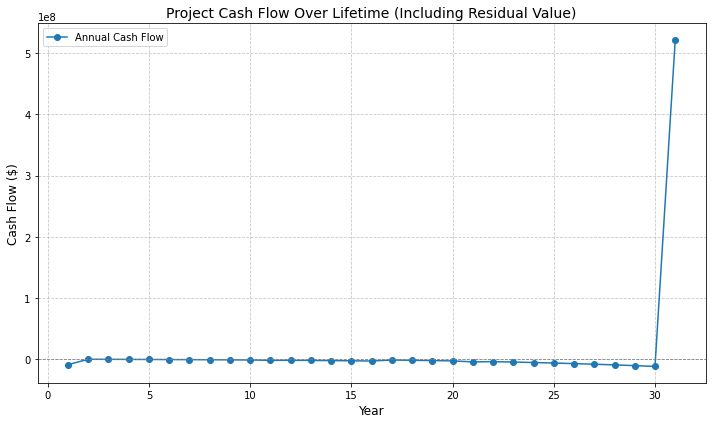

In [45]:

# Plotting the cash flow
years = list(range(1, project_lifetime + 2))

plt.figure(figsize=(10, 6))
plt.plot(years, cash_flows, label="Annual Cash Flow", marker='o')
# plt.plot(years, cumulative_cash_flows, label="Cumulative Cash Flow", linestyle="--")

# Adding labels, title, and legend
plt.title("Project Cash Flow Over Lifetime (Including Residual Value)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Cash Flow ($)", fontsize=12)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Add a horizontal line at y=0
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()











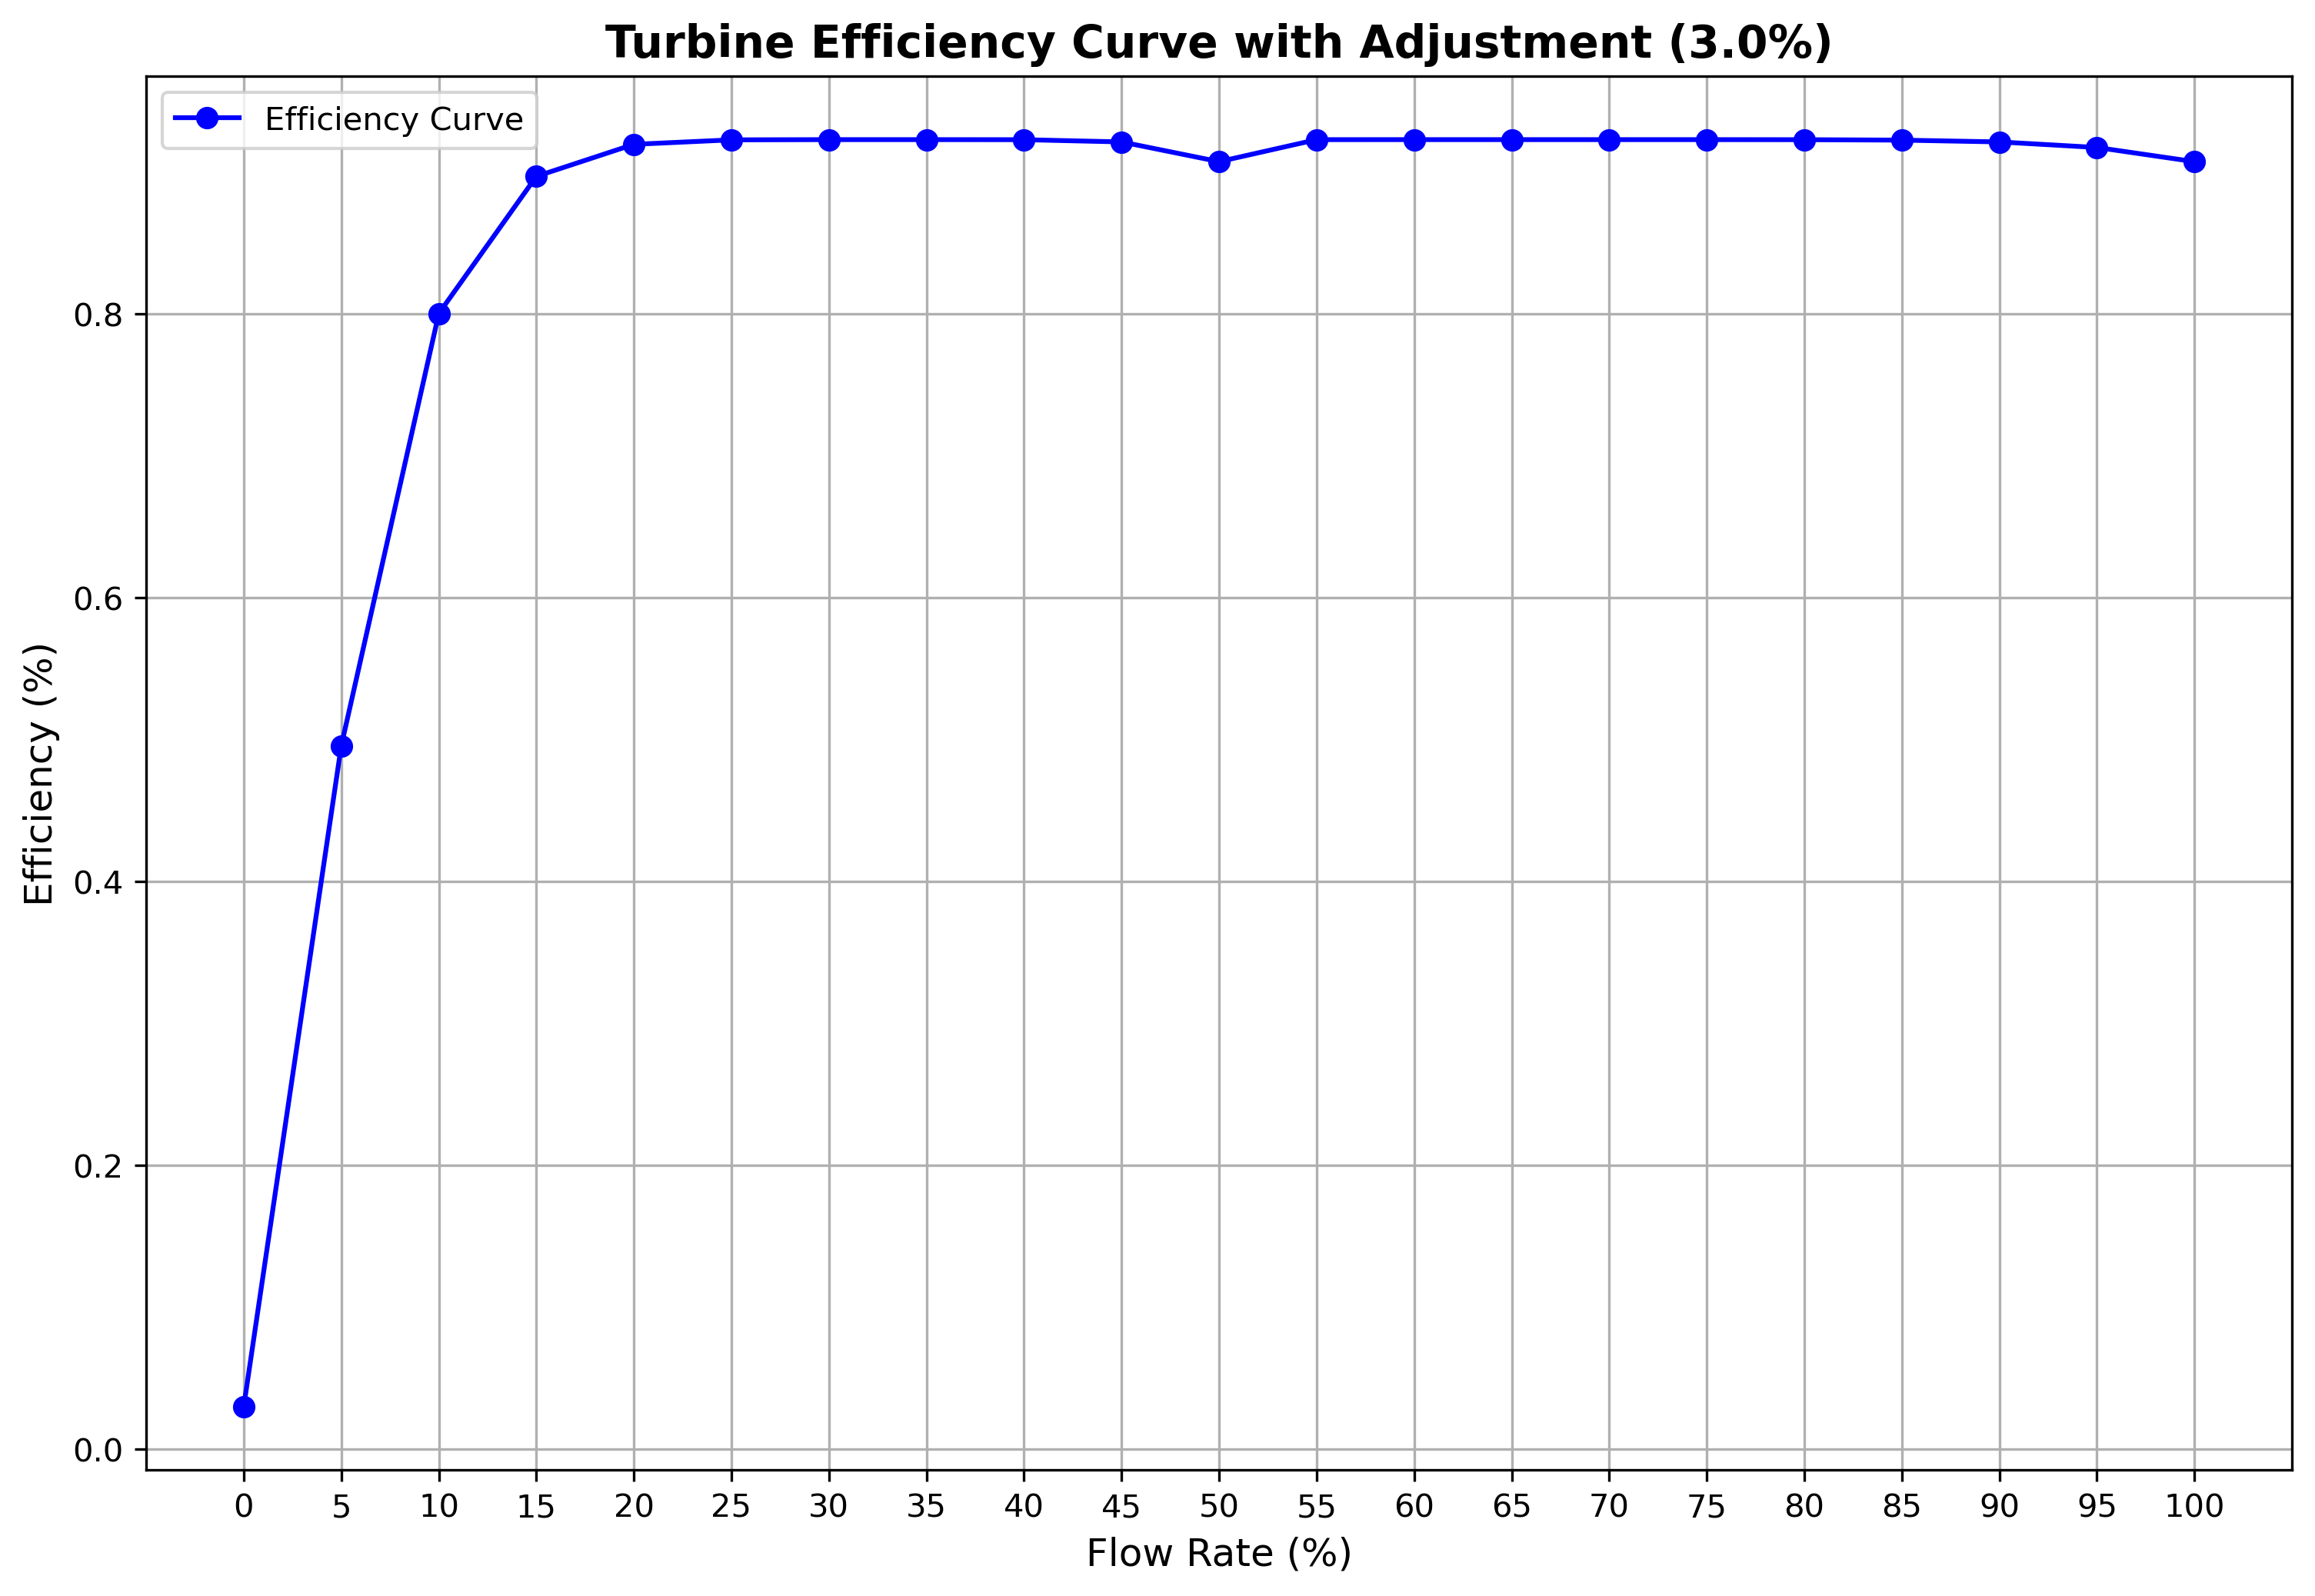

In [46]:



# #=============================TURBINE EFFECIENCY CURVE PLOT
# Plot the Turbine Efficiency Curve with adjusted values
plt.figure(figsize=(12, 8), dpi=300)
plt.plot(flow_percentages, adjusted_efficiencies, marker='o', linestyle='-', color='b', label="Efficiency Curve")
plt.title(f"Turbine Efficiency Curve with Adjustment ({efficiency_adjustment:.1f}%)", fontsize=14,   weight='bold')
plt.xlabel("Flow Rate (%)", fontsize=12)
plt.ylabel("Efficiency (%)", fontsize=12)
plt.grid(True)
plt.xticks(np.arange(0, 101, 5))
plt.legend()
plt.show()





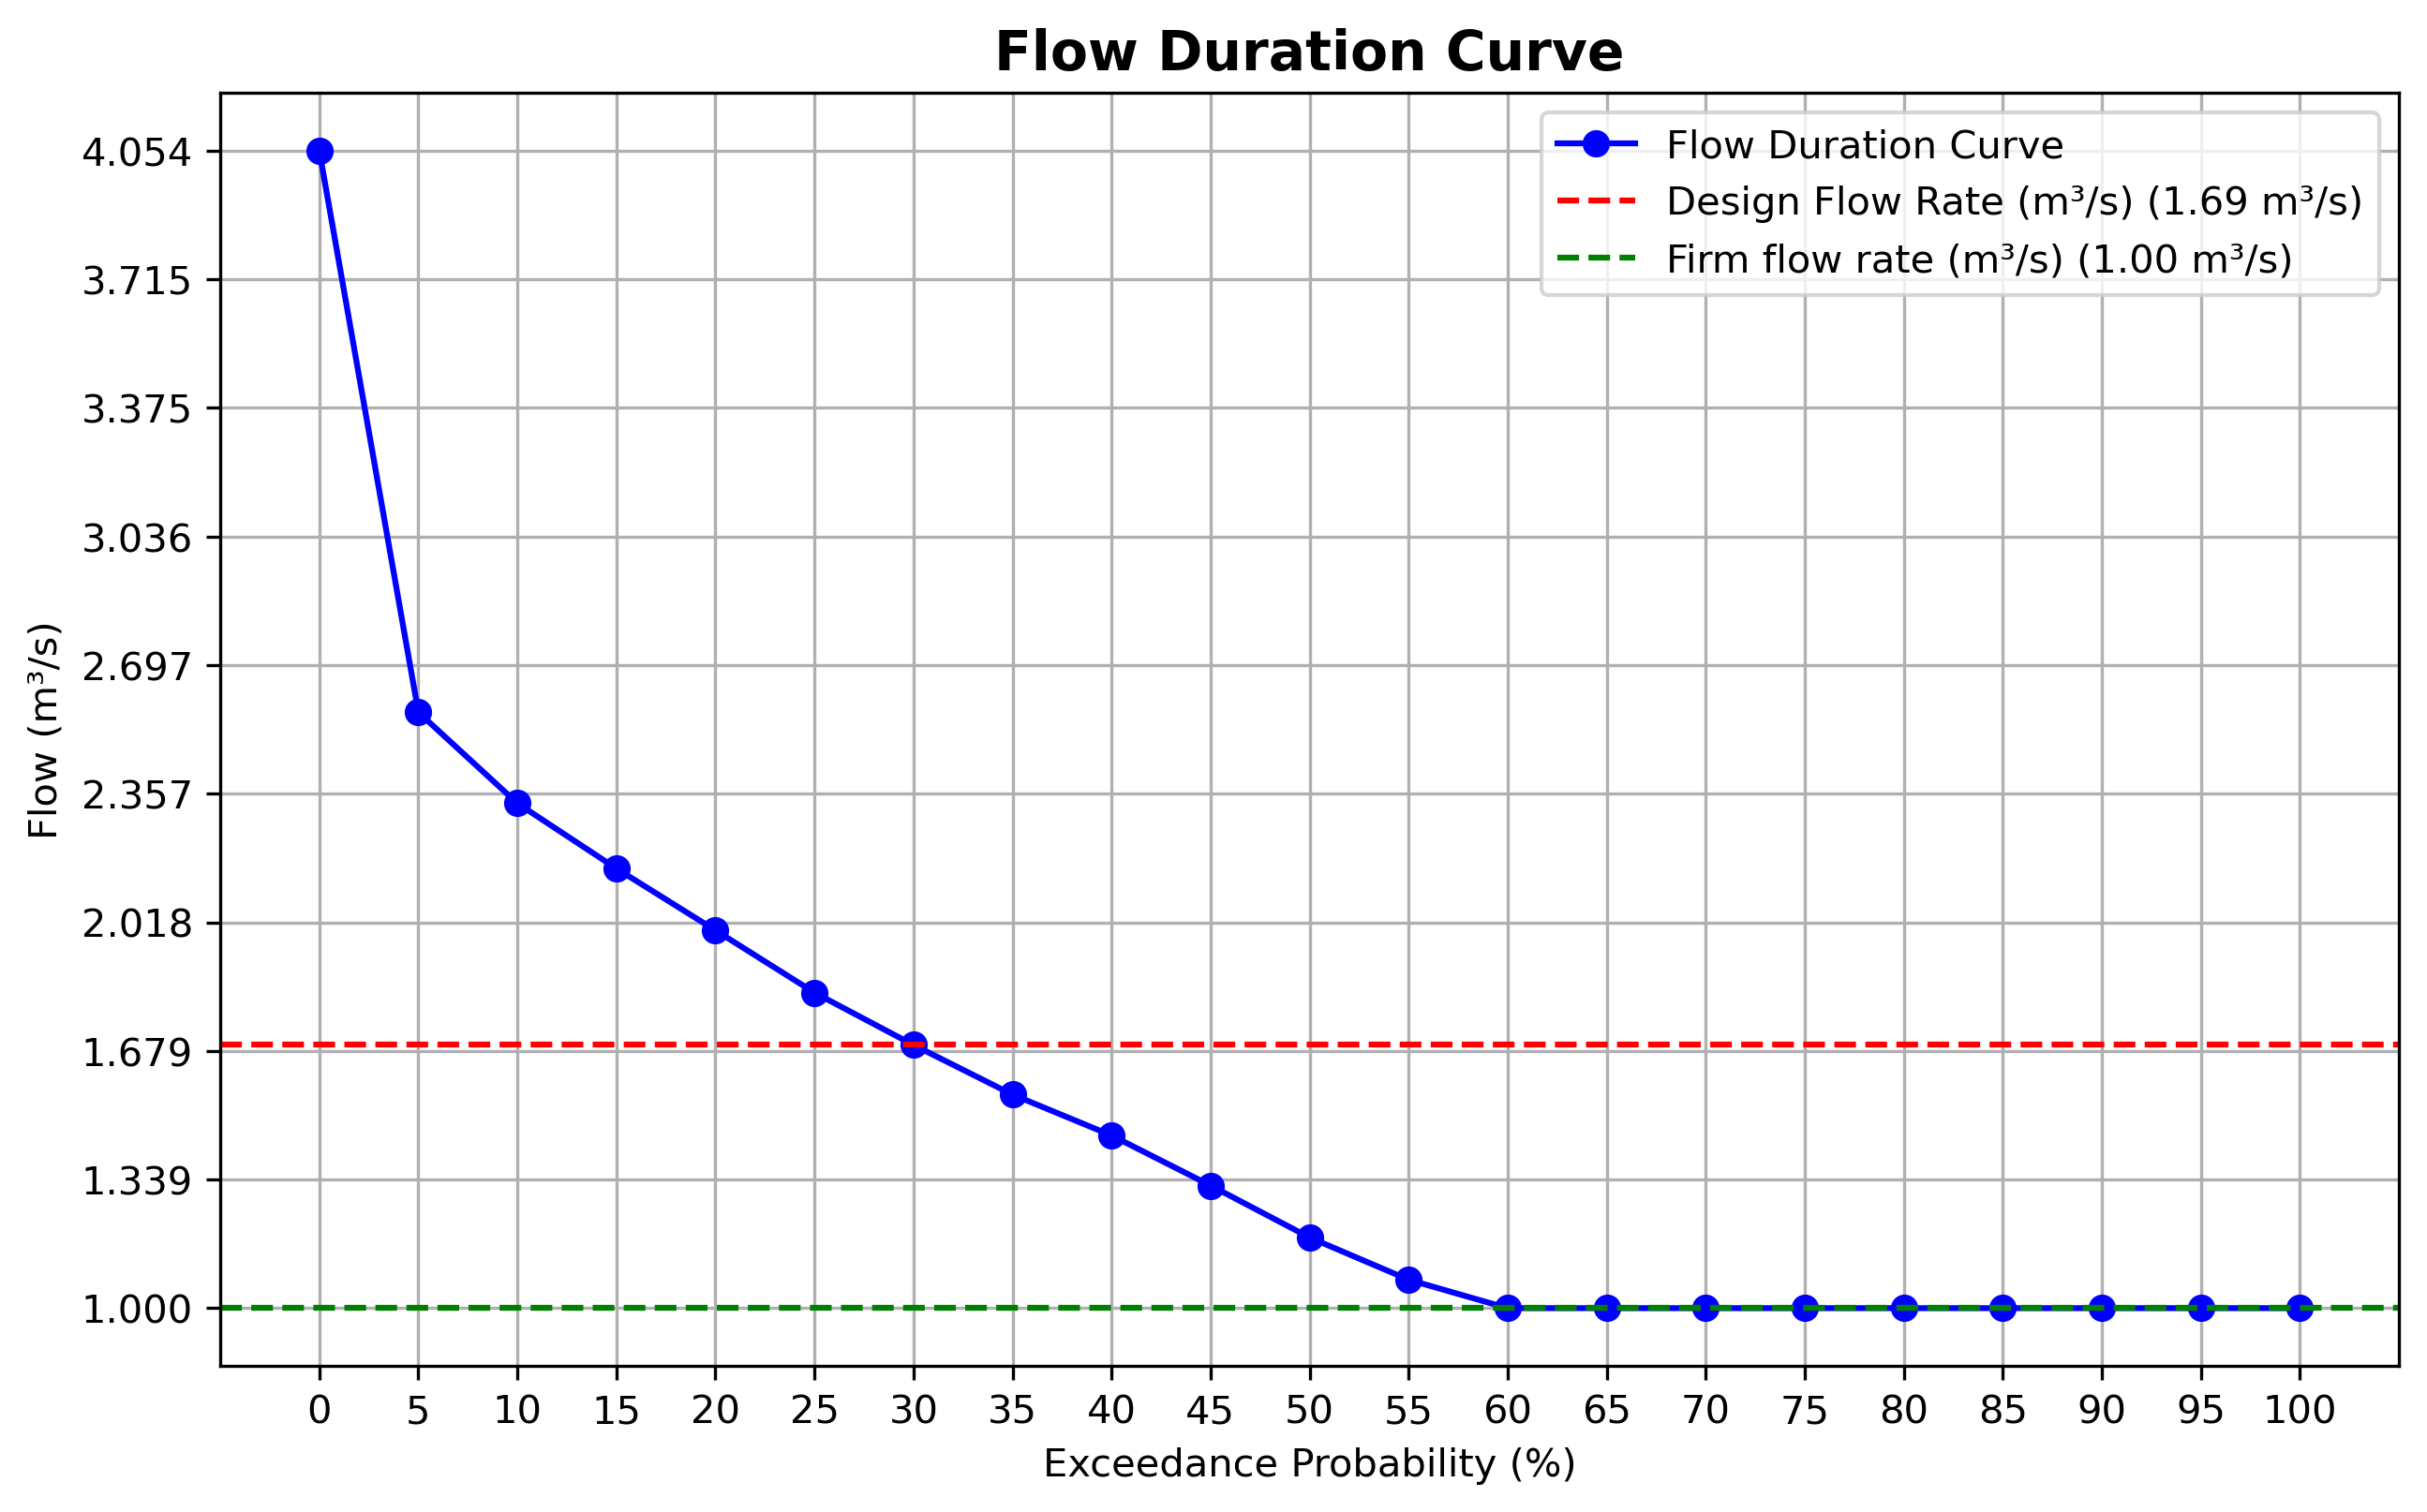

In [47]:

# #============================================FLOW DURATION CURVE

# Plot the Flow Duration Curve (FDC)
design_flow_30=rate_flow[6] 
Firm_flow_90=rate_flow[18] 


plt.figure(figsize=(10, 6), dpi=300)
plt.plot(percentiles, rate_flow, marker='o', linestyle='-', color='b', label="Flow Duration Curve")

# Show the design flow at 30th percentile
# Add a horizontal line for the 30th percentile design flow
plt.axhline(design_flow_30, color='red', linestyle='--', label=f'Design Flow Rate (m³/s) ({design_flow_30:.2f} m³/s)')
plt.axhline(Firm_flow_90, color='green', linestyle='--', label=f'Firm flow rate (m³/s) ({Firm_flow_90:.2f} m³/s)')

plt.title("Flow Duration Curve",fontsize=14,   weight='bold' )
plt.xlabel("Exceedance Probability (%)")
plt.ylabel("Flow (m³/s)")
plt.grid(True)
plt.xticks(np.arange(0, 101, 5))
plt.yticks(np.linspace(np.min(sorted_flow), np.max(sorted_flow), num=10))
plt.legend()
plt.show()

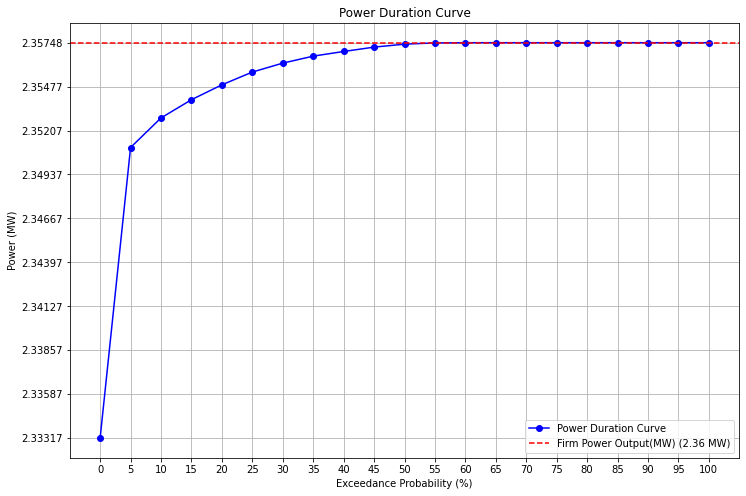

In [48]:

##============================================ # #POWER DURATION CURVE PLOT
Firm_power=Power_output[18]

plt.figure(figsize=(12, 8))
plt.plot(percentiles, Power_output, marker='o', linestyle='-', color='b', label="Power Duration Curve")
plt.axhline(Firm_power, color='red', linestyle='--', label=f'Firm Power Output(MW) ({Firm_power:.2f} MW)')


plt.title("Flow Duration Curve")
plt.xlabel("Exceedance Probability (%)")
plt.title("Power Duration Curve")
plt.xlabel("Exceedance Probability (%)")
plt.ylabel("Power (MW)")
plt.grid(True)
plt.xticks(np.arange(0, 101, 5))
plt.yticks(np.linspace(np.min(Power_output), np.max(Power_output), num=10))
plt.legend()
plt.show()

PDC=[]
PDC.append(percentiles)
PDC.append(Power_output)
pdc=pd.DataFrame(PDC)
